# Churn Model for Digital Marketing Clients

##### Author: Yuji Mori
##### Date: 05/18/2021

## Introduction

This predictive modeling challenge was completed for a marketing agency with a portfolio of various clients in the media space. The agency runs marketing campaigns on behalf of the clients, with varying degress of success. The objective is to create a model that predicts churn, given 9 predictor variables. **This code notebook is an exhibition of the work I performed for the agency, and all identifiable information and data has been removed**.


## Data

The data is in tabular (.csv) format with exactly 10,000 rows, each row representing a unique client. The data includes key metrics relating to the performance of the client campaign(s), such as client CPL (cost-per-lead), calls/clicks received, and their overall budget. There is also demographic information such as the client’s industry and age (months) in the portfolio. Finally, there is a flag column indicating whether the client has churned or not.

Looking at the variables, we can intuitively expect:
- higher engagement numbers (clicks, calls, etc.)
- negative CPL (i.e. cost is going down over time)
- longer duration in portfolio

to be indicative of successful marketing campaigns, and therefore smaller likelihood of churn. During model development, we will keep these expectations in mind.


## Model Development
### Step 1. Data Import and Pre-Processing

In [185]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix

In [19]:
df = pd.read_csv('assets/data.csv', header = None)
colnames = ['CPL_wrt_BC','client_state',
           'duration','num_products','calls',
           'CPL_wrt_self','churn','avg_budget',
           'BC','clicks']
df.columns = colnames

In [15]:
df.shape

(10000, 10)

#### Checking for Duplicate Entries
Below is a simple way to check whether there are any duplicate rows in the dataset. Usually we would opt to use some sort of identifying column (i.e. unique client ID)

In [170]:
df[df.duplicated()].empty

True

#### Missing Value Imputation

Models in Sklearn generally do not handle missing values, so it is advised to impute:

In [22]:
# Check each column for NaN values:
df.isna().sum()

CPL_wrt_BC         0
client_state       0
duration           0
num_products       0
calls              0
CPL_wrt_self    1092
churn              0
avg_budget         0
BC                 0
clicks             0
dtype: int64

In [35]:
# for now, just filling with 0:
df.CPL_wrt_self = df.CPL_wrt_self.fillna(0)

-------

### Step 2: Exploratory Analysis

#### The Response Variable:

In [48]:
df['churn'].value_counts()

0    8000
1    2000
Name: churn, dtype: int64

One of the most important variables to check is our response variable, `churn`. Our Portfolio has a **20% churn rate**.

------

#### Numeric Variables of Interest:

array([[<AxesSubplot:title={'center':'duration'}>]], dtype=object)

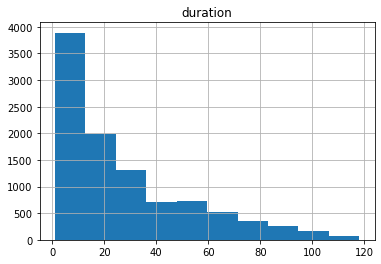

In [34]:
pd.DataFrame.hist(df, 'duration')

In a real business context, it could be useful to separate portfolio based on months duration, i.e. we can create separate categories/levels for 'new' accounts and 'old/aged' accounts. 

For example, we might be interested in a model that performs really well on new accounts specifically.

array([[<AxesSubplot:title={'center':'num_products'}>]], dtype=object)

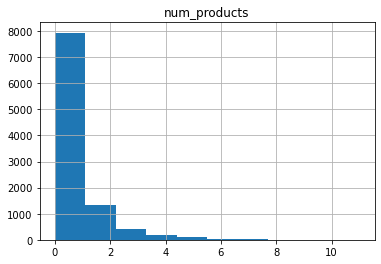

In [47]:
pd.DataFrame.hist(df, 'num_products')

A similar strategy could be applied to the number of products, but the data we have is mostly represented by clients with only 1 product.

array([[<AxesSubplot:title={'center':'avg_budget'}>]], dtype=object)

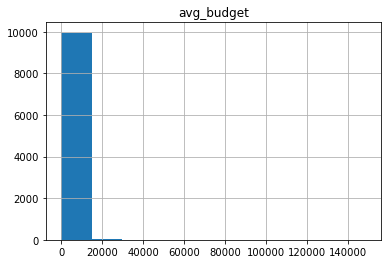

In [65]:
pd.DataFrame.hist(df,'avg_budget')

array([[<AxesSubplot:title={'center':'avg_budget'}>]], dtype=object)

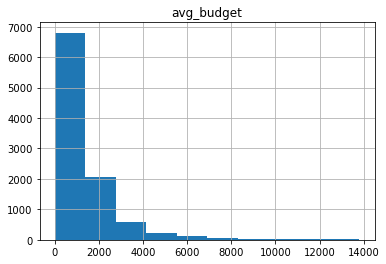

In [64]:
pd.DataFrame.hist(df[df['avg_budget']<=14000], 'avg_budget')

In [ ]:
# some accounts with noticeably high budgets:
df[df['avg_budget']>25000].sort_values(by='avg_budget',ascending=False).head()

The fact our highest-budget account has churned requires special attention, as it might have an impact on our model.  With that said, I have decided not remove any of these data points or treat them as outliers.

As mentioned earlier, it may be useful to split the portfolio by the overall budget of each client (for example: >= $100,000 as LARGE, <= 10,000 as SMALL, else MEDIUM) and determine how well the model performs for each segment.



#### Correlation Plot of Numeric Variables

<AxesSubplot:>

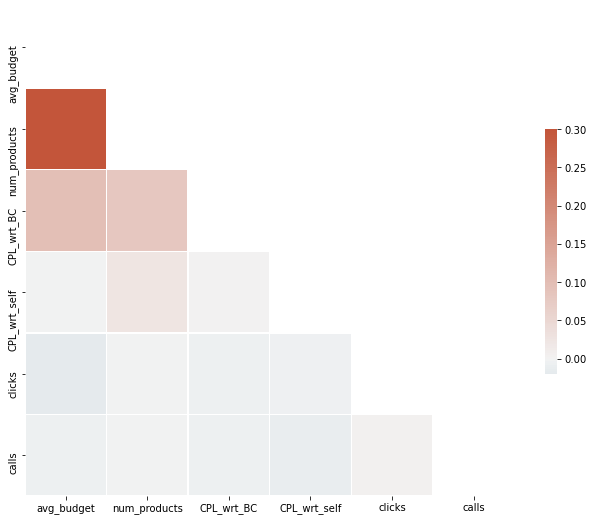

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[['avg_budget','num_products','CPL_wrt_BC','CPL_wrt_self','clicks','calls']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Looking at the correlation, there doesn't seem to be any strong relationships between the numeric variables, with the exception of `avg_budget` and `num_products`.

-----

#### Categorical Variables of Interest:

In [45]:
# Making sure all states are represented in the dataset:
df['client_state'].nunique()

51

In [ ]:
# checking frequency distribution:
df['client_state'].value_counts()

we see that all states are represented, though naturally the largers states (CA, FL, NY, etc.) have higher frequencies.

Next we take a look at the Business Categories:

In [53]:
df['BC'].nunique()

31

In [ ]:
df['BC'].value_counts()

Interestingly, the portfolio is predominantly made up of `Home & Home Improvement` clients, accounting for over 26% of the data. The resulting model might have a difficult time predicting inputs with uncommon business categories.

#### Dummy Encoding of Categorical Variables

Finally, before we proceed to model training, it is necessary to one-hot (dummy) encode our categorical variables (`client_state` and `BC`):

In [36]:
df_dummy = pd.get_dummies(df)

In [38]:
df_dummy.shape

(10000, 90)

### Step 3: Model Training

In [40]:
y = df_dummy['churn']
X = df_dummy.drop('churn',axis = 1)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

#### Model 1: Random Forest Classifier

In [98]:
model1 = RandomForestClassifier(n_estimators = 200, max_depth = 50, random_state=42)
model1.fit(Xtrain, ytrain)

RandomForestClassifier(max_depth=50, n_estimators=200, random_state=42)

##### Top 10 Features by Feature Importance:

In [132]:
pd.Series(model1.feature_importances_, index = X.columns).sort_values(ascending=False)[0:10]

CPL_wrt_self                  0.141963
CPL_wrt_BC                    0.131935
duration                      0.129412
avg_budget                    0.121802
clicks                        0.100541
calls                         0.064223
num_products                  0.020412
BC_Home & Home Improvement    0.014447
client_state_CA               0.013094
client_state_FL               0.009709
dtype: float64

#### Model 2: Gradient Boosted Trees

In [101]:
model2 = GradientBoostingClassifier(n_estimators = 200, max_depth = 50, random_state=42)
model2.fit(Xtrain, ytrain)

GradientBoostingClassifier(max_depth=50, n_estimators=200, random_state=42)

##### Top 10 Features by Feature Importance: 

In [133]:
pd.Series(model2.feature_importances_, index = X.columns).sort_values(ascending=False)[0:10]

CPL_wrt_BC                    0.190763
CPL_wrt_self                  0.144195
duration                      0.121634
avg_budget                    0.119779
clicks                        0.103555
calls                         0.051647
num_products                  0.017325
client_state_FL               0.010348
BC_Home & Home Improvement    0.009048
client_state_CA               0.008933
dtype: float64

##### Model 3 (not used): Logistic Regression Model

In [129]:
model3 = LogisticRegression(solver='liblinear', class_weight = 'balanced')
model3.fit(Xtrain, ytrain)

LogisticRegression(class_weight='balanced', solver='liblinear')

In [130]:
ypred3 = model3.predict(Xtest)
confusion_matrix(ytest, ypred3)

array([[908, 685],
       [176, 231]])

### Step 4: Model Evaluation

For model evaluation of a binary classification problem, it is very useful to first look at the **confusion matrix**, from which we can calculate performance metrics like **F-score**, **overall accuracy score** and **AUC score**.

In [191]:
ypred1 = model1.predict(Xtest)
pd.DataFrame(confusion_matrix(ytest, ypred1),
    index=['true:no', 'true:yes'], 
    columns=['pred:no', 'pred:yes'])

,pred:no,pred:yes
true:no,1569,24
true:yes,311,96


In [186]:
fscore1 = f1_score(ytest, ypred1)
acc1 = accuracy_score(ytest, ypred1)
auc1 = roc_auc_score(ytest, ypred1)

In [192]:
ypred2 = model2.predict(Xtest)
pd.DataFrame(confusion_matrix(ytest, ypred2),
    index=['true:no', 'true:yes'], 
    columns=['pred:no', 'pred:yes'])

,pred:no,pred:yes
true:no,1361,232
true:yes,257,150


In [187]:
fscore2 = f1_score(ytest, ypred2)
acc2 = accuracy_score(ytest, ypred2)
auc2 = roc_auc_score(ytest, ypred2)

In [188]:
tn1, fp1, fn1, tp1 = confusion_matrix(ytest, ypred1).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(ytest, ypred2).ravel()
fpr1 = fp1 / (fp1+tn1)
tpr1 = tp1 / (tp1 + fn1)
fpr2 = fp2 / (fp2+tn2)
tpr2 = tp2 / (tp2 + fn2)
tnr1 = tn1 / (tn1 + fp1)
tnr2 = tn2 / (tn2 + fp2)

pd.DataFrame({'Random Forest' : [fscore1, acc1, auc1, fpr1, tpr1, tnr1], 
              'Gradient-Boosted' : [fscore2, acc2, auc2, fpr2, tpr2, tnr2]
             },
            index = ['F Score','Accuracy','AUC','False Postive Rate (FPR)', 
                     'True Positive Rate (TPR)', 'True Negative Rate (TNR)']
            )

,Random Forest,Gradient-Boosted
F Score,0.364326,0.380228
Accuracy,0.832500,0.755500
AUC,0.610403,0.611457
False Postive Rate (FPR),0.015066,0.145637
True Positive Rate (TPR),0.235872,0.368550
True Negative Rate (TNR),0.984934,0.854363


**True Positive Rate:** The ability to correctly label churners. Arguably, this is the most important metric of our model, since it is crucial that we can identify churners before they churn. In this measure, the Gradient-Boosted model performs best.

**False Positive Rate:** The tendency of the model to falsely label non-churners as churners. This metric should be minimized, or else we might spend extra resources on clients that were not at risk of churning. The XGB model seems to be more liberal with classifying churners, therefore FPR, just like TPR, is higher.

**True Negative Rate:**  The ability to correctly label non-churners. The Random Forest model does a splendid job with this metric because it tends to classify most clients as non-churners (as it should, since churning is supposed to be a rare event).


All of these metrics are important to manage, but in the end, the business context is what matters most. **I conclude that the Gradient-Boosted Model is the best model because it correctly churners at a high rate, while also maintaining reasonably high metrics in other areas like Accuracy, AUC, and F-score.**



### Step 5: Segmentation Analysis

We will illustrate an example of segmentation analysis using the `avg_budget` column. Basically, the model performance will be assessed on both 'small' and 'big' budget clients.
I arbitrarily set the threshold for these two groups at $2000.


In [193]:
ypred2_small_budget = ypred2[Xtest['avg_budget']<= 2000]
ytest_small_budget = ytest[Xtest['avg_budget']<= 2000]

ypred2_big_budget = ypred2[Xtest['avg_budget']> 2000]
ytest_big_budget = ytest[Xtest['avg_budget']> 2000]

matrix_sb = pd.DataFrame(
    confusion_matrix(ytest_small_budget, ypred2_small_budget), 
    index=['true:no', 'true:yes'], 
    columns=['pred:no', 'pred:yes']
)

matrix_bb = pd.DataFrame(
    confusion_matrix(ytest_big_budget, ypred2_big_budget), 
    index=['true:no', 'true:yes'], 
    columns=['pred:no', 'pred:yes']
)

In [194]:
matrix_sb

,pred:no,pred:yes
true:no,1062,192
true:yes,220,137


In [195]:
tn, fp, fn, tp = matrix_sb.iloc[0,0], matrix_sb.iloc[0,1], matrix_sb.iloc[1,0], matrix_sb.iloc[1,1]
fpr = fp / (fp+tn)
print(fpr)
tpr = tp / (tp + fn)
print(tpr)

0.15311004784688995
0.38375350140056025


In [196]:
matrix_bb

,pred:no,pred:yes
true:no,299,40
true:yes,37,13


In [197]:
tn, fp, fn, tp = matrix_bb.iloc[0,0], matrix_bb.iloc[0,1], matrix_bb.iloc[1,0], matrix_bb.iloc[1,1]
fpr = fp / (fp+tn)
print(fpr)
tpr = tp / (tp + fn)
print(tpr)

0.11799410029498525
0.26


The results of this analysis show that our model performs significantly better on clients with smaller marketing budgets. I draw this conclusion based on the **true positive rate** metric. The sample size is lacking for the 'large' budget segment, so a more balanced dataset may yield better predictions.

We can repeat this analysis on various other columns of our data for further insights. My ideas for segmentation are discussed earlier in the Exploratory Analysis section of this document.

-----

## Business Impact

The end goal of this prediction model is to allow the business to focus marketing and retention efforts on the clients that are most likely to churn. Below, we illustrate the dollar amount in revenue we would save with early detection of clients that ended up churning:

In [198]:
# amount of revenue saved by correct predictions:
sum(Xtest['avg_budget'][(ypred2 == ytest) & (ytest == 1)])

132090.77539451193

In [199]:
# average of avg_budget for entire dataset:
np.mean(X['avg_budget'])

1512.601132172423

In [162]:
# still about a 20% churn rate in our test sample:
ytest.value_counts()

0    1593
1     407
Name: churn, dtype: int64

The total comes out to be nearly **$132,000** on our test sample of only 2,000 accounts (~400 churn). 

Now suppose we have a fresh dataset with 10,000 more clients. Also assume a similar 20 percent churn rate and ~\\$1,500 average marketing budget per account. This model detects about 37 percent of churners, which comes out to: (\\$1,500 * 2,000 * 0.37) = **over \\$1,000,000 saved!**